In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
import seaborn as sns
from itertools import product
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels import spectrum_kernel
from codes.kernels_pairwise import spectrum_kernel_pw, sum_onehot_spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

# A: whole RBS sequence (len: 29)
# B: extracted 20-base RBS seqeunce (A[7:27], len: 20), training features
# C: TIR labels
# D: the design part RBS (B[7:13], len: 6) 

#Path = '../../data/First_round_results/Results - First Plate 3 reps.csv'
Path = '../../data/firstRound_4h.csv'


df = pd.read_csv(Path)
df.head()

,RBS,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,RBS6
0,ATGTATATCTCCTTCTTAAA,2.648575,2.680900,1.260311,2.196595,0.811007,0.165450,TCTCCT
1,ATGTATATCTCCTTCTTAAG,1.399539,1.651162,0.814621,1.288441,0.429194,0.065275,TCTCCT
2,ATGTATATCTCCTTCTTAAC,0.317903,0.478171,0.247558,0.347877,0.118192,0.054851,TCTCCT
3,ATGTATATCTCCTTCTTAAT,1.531393,1.251007,0.649089,1.143829,0.450811,0.142442,TCTCCT
4,ATGTATATCTCCTTCTTAGA,1.386412,1.812794,0.545837,1.248348,0.644664,0.041654,TCTCCT


In [3]:
df['Group'] = 'bsp'
#uni_random_30 = df[60:90]
df.loc[60:90, 'Group'] = 'uni random'

## Violinplot with AVERAGE value

In [4]:
df.sort_values(by = ['AVERAGE'], ascending = False).head(10)

,RBS,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,RBS6,Group
0,ATGTATATCTCCTTCTTAAA,2.648575,2.680900,1.260311,2.196595,0.811007,0.165450,TCTCCT,bsp
47,ATGTTTATCTCCTTCTTAAA,2.141188,2.139832,0.476877,1.585965,0.960499,0.105634,TCTCCT,bsp
11,ATGTATATCTCCTTCTAAAA,1.774019,2.292778,0.690337,1.585711,0.817649,0.039328,TCTCCT,bsp
10,ATGTATATCTCCTTCTCAAA,1.687891,1.983839,0.522269,1.397999,0.772706,0.064490,TCTCCT,bsp
7,ATGTATATCTCCTTCTTCAA,1.336007,1.444988,NaN,1.390498,0.077061,0.084279,TCTCCT,bsp
59,TTGTATATCTCCTTCTTAAA,2.258413,1.951785,-0.211412,1.332929,1.346197,0.142840,TCTCCT,bsp
1,ATGTATATCTCCTTCTTAAG,1.399539,1.651162,0.814621,1.288441,0.429194,0.065275,TCTCCT,bsp
4,ATGTATATCTCCTTCTTAGA,1.386412,1.812794,0.545837,1.248348,0.644664,0.041654,TCTCCT,bsp
12,ATGTATATCTCCTTCGTAAA,1.385265,1.440498,0.686775,1.170846,0.420126,0.092591,TCTCCT,bsp
3,ATGTATATCTCCTTCTTAAT,1.531393,1.251007,0.649089,1.143829,0.450811,0.142442,TCTCCT,bsp


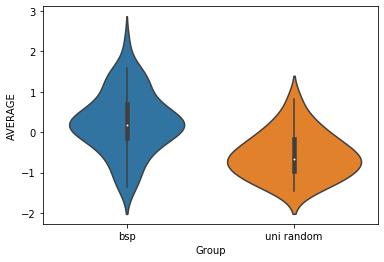

In [5]:
sns.violinplot(x="Group", y="AVERAGE", data=df)

## Violinplot with all replications

In [6]:
df_all_rep = pd.melt(df, id_vars=['RBS', 'Group'], value_vars=['Rep1', 'Rep2', 'Rep3'])
df_all_rep = df_all_rep.dropna()

In [7]:
df_all_rep.sort_values(by = ['value'], ascending = False).head(10)

,RBS,Group,variable,value
89,ATGTATATCTCCTTCTTAAA,bsp,Rep2,2.680900
0,ATGTATATCTCCTTCTTAAA,bsp,Rep1,2.648575
100,ATGTATATCTCCTTCTAAAA,bsp,Rep2,2.292778
59,TTGTATATCTCCTTCTTAAA,bsp,Rep1,2.258413
47,ATGTTTATCTCCTTCTTAAA,bsp,Rep1,2.141188
136,ATGTTTATCTCCTTCTTAAA,bsp,Rep2,2.139832
99,ATGTATATCTCCTTCTCAAA,bsp,Rep2,1.983839
148,TTGTATATCTCCTTCTTAAA,bsp,Rep2,1.951785
93,ATGTATATCTCCTTCTTAGA,bsp,Rep2,1.812794
11,ATGTATATCTCCTTCTAAAA,bsp,Rep1,1.774019


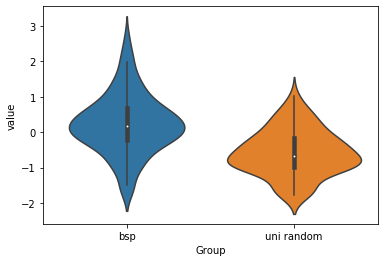

In [8]:
sns.violinplot(x="Group", y="value", data=df_all_rep)

## Predict labels with baseline data as training data

In [12]:
import pickle

with open('trained_reg_model.pickle', 'rb') as handle:
    trained_reg_model_dict = pickle.load(handle)

In [13]:
first_round_seq = Rewards_env(np.asarray(df[['RBS', 'AVERAGE']]), 'label').embedded
df['predict mean'], df['predict std']= trained_reg_model_dict['Baseline data_First round result_GPR_sospec_label'].predict(first_round_seq, return_std=True)
# df['AVERAGE'] = (df['AVERAGE']-df['AVERAGE'].mean())/df['AVERAGE'].std()
df.head()

,RBS,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,RBS6,Group,predict mean,predict std
0,ATGTATATCTCCTTCTTAAA,2.648575,2.680900,1.260311,2.196595,0.811007,0.165450,TCTCCT,bsp,0.633606,3.502743
1,ATGTATATCTCCTTCTTAAG,1.399539,1.651162,0.814621,1.288441,0.429194,0.065275,TCTCCT,bsp,0.540787,3.573123
2,ATGTATATCTCCTTCTTAAC,0.317903,0.478171,0.247558,0.347877,0.118192,0.054851,TCTCCT,bsp,0.396645,3.617307
3,ATGTATATCTCCTTCTTAAT,1.531393,1.251007,0.649089,1.143829,0.450811,0.142442,TCTCCT,bsp,0.019547,3.556286
4,ATGTATATCTCCTTCTTAGA,1.386412,1.812794,0.545837,1.248348,0.644664,0.041654,TCTCCT,bsp,0.868324,3.629047


In [14]:
df.sort_values(by = ['AVERAGE'], ascending = False).head(10)

,RBS,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,RBS6,Group,predict mean,predict std
0,ATGTATATCTCCTTCTTAAA,2.648575,2.680900,1.260311,2.196595,0.811007,0.165450,TCTCCT,bsp,0.633606,3.502743
47,ATGTTTATCTCCTTCTTAAA,2.141188,2.139832,0.476877,1.585965,0.960499,0.105634,TCTCCT,bsp,0.850861,3.562416
11,ATGTATATCTCCTTCTAAAA,1.774019,2.292778,0.690337,1.585711,0.817649,0.039328,TCTCCT,bsp,0.330231,3.273253
10,ATGTATATCTCCTTCTCAAA,1.687891,1.983839,0.522269,1.397999,0.772706,0.064490,TCTCCT,bsp,0.470444,3.501564
7,ATGTATATCTCCTTCTTCAA,1.336007,1.444988,NaN,1.390498,0.077061,0.084279,TCTCCT,bsp,-0.216698,3.518314
59,TTGTATATCTCCTTCTTAAA,2.258413,1.951785,-0.211412,1.332929,1.346197,0.142840,TCTCCT,bsp,0.118385,3.511120
1,ATGTATATCTCCTTCTTAAG,1.399539,1.651162,0.814621,1.288441,0.429194,0.065275,TCTCCT,bsp,0.540787,3.573123
4,ATGTATATCTCCTTCTTAGA,1.386412,1.812794,0.545837,1.248348,0.644664,0.041654,TCTCCT,bsp,0.868324,3.629047
12,ATGTATATCTCCTTCGTAAA,1.385265,1.440498,0.686775,1.170846,0.420126,0.092591,TCTCCT,bsp,1.028252,3.523056
3,ATGTATATCTCCTTCTTAAT,1.531393,1.251007,0.649089,1.143829,0.450811,0.142442,TCTCCT,bsp,0.019547,3.556286


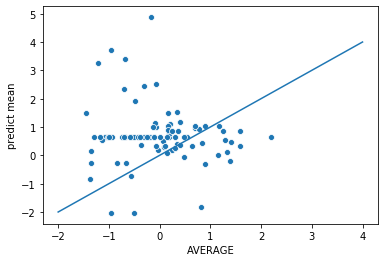

In [16]:
sns.scatterplot(df['AVERAGE'], df['predict mean'])
sns.lineplot([-2,4], [-2,4])